In [ ]:
import os
!rm -r sample_data

#clone repo AttnGAN
!git clone https://github.com/taoxugit/AttnGAN.git

#Changing Working dirctory to data
os.chdir('/content/AttnGAN/data/')
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1O_LtUP9sch09QH3s_EBAgLEctBQ5JBSJ' -O birds.zip
!unzip -q birds.zip
!rm birds.zip
!rm -r __MACOSX/

#Changing Working dirctory to birds
os.chdir('/content/AttnGAN/data/birds/')
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1hbzc_P1FuxMkcabkgn9ZKinBwW683j45' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1hbzc_P1FuxMkcabkgn9ZKinBwW683j45" -O CUB_200_2011.tgz && rm -rf /tmp/cookies.txt
!tar zxf  CUB_200_2011.tgz
!rm CUB_200_2011.tgz

#Changing Working dirctory to code
os.chdir('/content/AttnGAN/code/')
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Wr3lQajG7m6Bi3rYFTJb6mwE_d8su111' -O Pillow.rar
!unrar x  Pillow.rar
!rm Pillow.rar

In [ ]:
import os
os.chdir('/content/AttnGAN/code/')

import os.path as osp
import sys
import time
import random
import pprint
import datetime
import dateutil.tz
import numpy as np
import numpy.random as random
import pandas as pd
import pickle
from easydict import EasyDict as edict

from PIL import Image, ImageDraw, ImageFont
from copy import deepcopy
import skimage.transform

import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

from torchvision import models
import torchvision.transforms as transforms

import torch.utils.model_zoo as model_zoo
import torch.utils.data as data

from nltk.tokenize import RegexpTokenizer
from collections import defaultdict


__C = edict()
cfg = __C
__C.DATASET_NAME = 'birds'
__C.CONFIG_NAME = 'DAMSM'
__C.DATA_DIR = '../data/birds'
__C.GPU_ID = 0
__C.CUDA = True
__C.WORKERS = 1
__C.RNN_TYPE = 'LSTM'   # 'GRU'
__C.B_VALIDATION = False

__C.TREE = edict()
__C.TREE.BRANCH_NUM = 1
__C.TREE.BASE_SIZE = 299

# Training options
__C.TRAIN = edict()
__C.TRAIN.BATCH_SIZE = 48
__C.TRAIN.MAX_EPOCH = 600
__C.TRAIN.SNAPSHOT_INTERVAL = 50
__C.TRAIN.DISCRIMINATOR_LR = 0.0002
__C.TRAIN.GENERATOR_LR = 0.0002
__C.TRAIN.ENCODER_LR = 0.002
__C.TRAIN.RNN_GRAD_CLIP = 0.25
__C.TRAIN.FLAG = True
__C.TRAIN.NET_E = ''
__C.TRAIN.NET_G = ''
__C.TRAIN.B_NET_D = True
__C.TRAIN.SMOOTH = edict()
__C.TRAIN.SMOOTH.GAMMA1 = 4.0
__C.TRAIN.SMOOTH.GAMMA3 = 10.0
__C.TRAIN.SMOOTH.GAMMA2 = 5.0
__C.TRAIN.SMOOTH.LAMBDA = 1.0

# Modal options
__C.GAN = edict()
__C.GAN.DF_DIM = 64
__C.GAN.GF_DIM = 128
__C.GAN.Z_DIM = 100
__C.GAN.CONDITION_DIM = 100
__C.GAN.R_NUM = 2
__C.GAN.B_ATTENTION = True
__C.GAN.B_DCGAN = False

__C.TEXT = edict()
__C.TEXT.CAPTIONS_PER_IMAGE = 10
__C.TEXT.EMBEDDING_DIM = 256
__C.TEXT.WORDS_NUM = 18



def get_imgs(img_path, imsize, bbox=None,
                transform=None, normalize=None):
    img = Image.open(img_path).convert('RGB')
    width, height = img.size
    if bbox is not None:
        r = int(np.maximum(bbox[2], bbox[3]) * 0.75)
        center_x = int((2 * bbox[0] + bbox[2]) / 2)
        center_y = int((2 * bbox[1] + bbox[3]) / 2)
        y1 = np.maximum(0, center_y - r)
        y2 = np.minimum(height, center_y + r)
        x1 = np.maximum(0, center_x - r)
        x2 = np.minimum(width, center_x + r)
        img = img.crop([x1, y1, x2, y2])

    if transform is not None:
        img = transform(img)

    ret = []
    if cfg.GAN.B_DCGAN:
        ret = [normalize(img)]
    else:
        for i in range(cfg.TREE.BRANCH_NUM):
            # print(imsize[i])
            if i < (cfg.TREE.BRANCH_NUM - 1):
                re_img = transforms.Scale(imsize[i])(img)
            else:
                re_img = img
            ret.append(normalize(re_img))

    return ret

def prepare_data(data):
    imgs, captions, captions_lens, class_ids, keys = data

    # sort data by the length in a decreasing order !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!MARKER!!!!!!!!!!!!!!!!!!!!!!!!
    sorted_cap_lens, sorted_cap_indices = torch.sort(captions_lens, 0, True)

    real_imgs = []
    for i in range(len(imgs)):
        imgs[i] = imgs[i][sorted_cap_indices]
        if cfg.CUDA:
            real_imgs.append(Variable(imgs[i]).cuda())
        else:
            real_imgs.append(Variable(imgs[i]))

    captions = captions[sorted_cap_indices].squeeze()
    class_ids = class_ids[sorted_cap_indices].numpy()
    # sent_indices = sent_indices[sorted_cap_indices]
    keys = [keys[i] for i in sorted_cap_indices.numpy()]
    # print('keys', type(keys), keys[-1])  # list
    if cfg.CUDA:
        captions = Variable(captions).cuda()
        sorted_cap_lens = Variable(sorted_cap_lens).cuda()
    else:
        captions = Variable(captions)
        sorted_cap_lens = Variable(sorted_cap_lens)

    return [real_imgs, captions, sorted_cap_lens,
            class_ids, keys]

def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

def build_super_images(real_imgs, captions, ixtoword,
                        attn_maps, att_sze, lr_imgs=None,
                        batch_size=cfg.TRAIN.BATCH_SIZE,
                        max_word_num=cfg.TEXT.WORDS_NUM):
    
    
    COLOR_DIC = {0:[128,64,128],  1:[244, 35,232],
                2:[70, 70, 70],  3:[102,102,156],
                4:[190,153,153], 5:[153,153,153],
                6:[250,170, 30], 7:[220, 220, 0],
                8:[107,142, 35], 9:[152,251,152],
                10:[70,130,180], 11:[220,20, 60],
                12:[255, 0, 0],  13:[0, 0, 142],
                14:[119,11, 32], 15:[0, 60,100],
                16:[0, 80, 100], 17:[0, 0, 230],
                18:[0,  0, 70],  19:[0, 0,  0]}
    FONT_MAX = 50

    
    build_super_images_start_time = time.time()
    nvis = 8
    real_imgs = real_imgs[:nvis]
    if lr_imgs is not None:
        lr_imgs = lr_imgs[:nvis]
    if att_sze == 17:
        vis_size = att_sze * 16
    else:
        vis_size = real_imgs.size(2)

    text_convas = \
        np.ones([batch_size * FONT_MAX,
                 (max_word_num + 2) * (vis_size + 2), 3],
                dtype=np.uint8)


    # print("keyword |||||||||||||||||||||||||||||||")
    # print("max_word_num : " , max_word_num)
    # print("keyword |||||||||||||||||||||||||||||||")
    for i in range(max_word_num):
        istart = (i + 2) * (vis_size + 2)
        iend = (i + 3) * (vis_size + 2)
        text_convas[:, istart:iend, :] = COLOR_DIC[i]


    real_imgs = \
        nn.Upsample(size=(vis_size, vis_size), mode='bilinear')(real_imgs)
    # [-1, 1] --> [0, 1]
    real_imgs.add_(1).div_(2).mul_(255)
    real_imgs = real_imgs.data.numpy()
    # b x c x h x w --> b x h x w x c
    real_imgs = np.transpose(real_imgs, (0, 2, 3, 1))
    pad_sze = real_imgs.shape
    middle_pad = np.zeros([pad_sze[2], 2, 3])
    post_pad = np.zeros([pad_sze[1], pad_sze[2], 3])
    if lr_imgs is not None:
        lr_imgs = \
            nn.Upsample(size=(vis_size, vis_size), mode='bilinear')(lr_imgs)
        # [-1, 1] --> [0, 1]
        lr_imgs.add_(1).div_(2).mul_(255)
        lr_imgs = lr_imgs.data.numpy()
        # b x c x h x w --> b x h x w x c
        lr_imgs = np.transpose(lr_imgs, (0, 2, 3, 1))

    # batch x seq_len x 17 x 17 --> batch x 1 x 17 x 17
    seq_len = max_word_num
    img_set = []
    num = nvis  # len(attn_maps)

    text_map, sentences = \
        drawCaption(text_convas, captions, ixtoword, vis_size)
    text_map = np.asarray(text_map).astype(np.uint8)

    bUpdate = 1
    for i in range(num):
        #print ("loop " , i ," of " , num == 8)
        attn = attn_maps[i].cpu().view(1, -1, att_sze, att_sze)
        # --> 1 x 1 x 17 x 17
        attn_max = attn.max(dim=1, keepdim=True)
        attn = torch.cat([attn_max[0], attn], 1)
        #
        attn = attn.view(-1, 1, att_sze, att_sze)
        attn = attn.repeat(1, 3, 1, 1).data.numpy()
        # n x c x h x w --> n x h x w x c
        attn = np.transpose(attn, (0, 2, 3, 1))
        num_attn = attn.shape[0]
        #
        img = real_imgs[i]
        if lr_imgs is None:
            lrI = img
        else:
            lrI = lr_imgs[i]
        
        row = [lrI, middle_pad]
        #print("rowwwwwwwwwwwwwwwww : ", row)
        row_merge = [img, middle_pad]
        row_beforeNorm = []
        minVglobal, maxVglobal = 1, 0
        for j in range(num_attn):
            #print ("looop " , j , " of " , seq_len+1)
            one_map = attn[j]
            #print("First one map : " , one_map.shape)
            #print("attn.shape : " , attn.shape)

            
            # print("if (vis_size // att_sze) > 1: " ,  (vis_size // att_sze) > 1)
            # print("vis_size : " , vis_size)
            # print("att_sze : " , att_sze)
            # print("vis_size//att_sze : " , vis_size//att_sze)
            
            if (vis_size // att_sze) > 1:
                one_map = \
                    skimage.transform.pyramid_expand(one_map, sigma=20,
                                                     upscale=vis_size // att_sze)
            #    print("one_map in if : " , one_map.shape)

            
            row_beforeNorm.append(one_map)
            #print("row_beforeNorm.append(one_map)" ,len(row_beforeNorm))
            minV = one_map.min()
            maxV = one_map.max()
            if minVglobal > minV:
                minVglobal = minV
            if maxVglobal < maxV:
                maxVglobal = maxV
            #print("seq_len : " , seq_len)
        for j in range(seq_len + 1):
            #print ("loooop " , j , " of " , seq_len+1)
            
            if j < num_attn:
                one_map = row_beforeNorm[j]
                one_map = (one_map - minVglobal) / (maxVglobal - minVglobal)
                one_map *= 255
                #
                # print ("PIL_im = " , Image.fromarray(np.uint8(img)))
                # print ("PIL_att = " , Image.fromarray(np.uint8(one_map[:,:,:3])))
                # print ("img.size( :" , img.shape)
                # print ("one_map.size( :" , one_map.shape)
                PIL_im = Image.fromarray(np.uint8(img))
                PIL_att = Image.fromarray(np.uint8(one_map[:,:,:3]))
                merged = \
                    Image.new('RGBA', (vis_size, vis_size), (0, 0, 0, 0))
                #print ("merged : " , merged.size)
                mask = Image.new('L', (vis_size, vis_size), (210))
                #print (" mask  : " , mask.size)
                merged.paste(PIL_im, (0, 0))
                #print (" merged.paste(PIL_im)  : " , merged.size )
                ############################################################
                merged.paste(PIL_att, (0, 0), mask)
                #print (" merged.paste(PIL_att)  : " ,  merged.size)#########################
                merged = np.array(merged)[:, :, :3]
                #print ("  np.array(merged)[:::3] : " , merged.size )#########################
                ############################################################
            else:
                #print (" IN THE ELSE post_pad : " , post_pad.shape)
                one_map = post_pad
                #print (" one_map  : " , one_map.shape )
                merged = post_pad
                #print ("  OUTTING THE ELSE : " , merged.shape )
            
            #print ("  row : " , len(row))
            row.append(one_map[:,:,:3])
            #print ("  row.appedn(one_map) : " , len(row))
            row.append(middle_pad)
            #print ("  row.append(middle_pad) : " , len(row))
            #
            #print ("  row_merge : " , len(row_merge))
            row_merge.append(merged)
            #print ("  row_merge.append(mereged) : " , len(row_merge) )
            row_merge.append(middle_pad)
            #print ("  row_merge.append(middle_pad) : " , len(row_merge) )
        ####################################################################
        # print("row.shape : ", len(row))
        # for i in range(len(row)):
        #   print('arr', i,   
        #         " => dim0:", len(row[i]),
        #         " || dim1:", len(row[i][0]),
        #         " || dim2:", len(row[i][0][0]))
        # #print(row)
        # print("row[0].shape : ", len(row[0]))
        # #print(row[0])
        # print("row[0][0].shape : ", len(row[0][0]))
        # #print(row[0][0])
        # print("row[0][0][0].shape : ", len(row[0][0][0]))
        # #print(row[0][0][0])

        # print("row[1].shape : ", len(row[1]))
        # #print(row[1])
        # print("row[1][0].shape : ", len(row[1][0]))
        # #print(row[1][0])
        # print("row[1][0][0].shape : ", len(row[1][0][0]))
        # #print(row[1][0][0])

        # print("row[2].shape : ", len(row[2]))
        # #print(row[2])
        # print("row[2][0].shape : ", len(row[2][0]))
        # #print(row[2][0])
        # print("row[2][0][0].shape : ", len(row[2][0][0]))
        # #print(row[2][0][0])

        # print("row[3].shape : ", len(row[3]))
        # #print(row[2])
        # print("row[3][0].shape : ", len(row[3][0]))
        # #print(row[2][0])
        # print("row[3][0][0].shape : ", len(row[3][0][0]))
        # #print(row[2][0][0])

        # print("row[4].shape : ", len(row[4]))
        # #print(row[2])
        # print("row[4][0].shape : ", len(row[4][0]))
        # #print(row[2][0])
        # print("row[4][0][0].shape : ", len(row[4][0][0]))
        #print(row[2][0][0])

        

        
        
        row = np.concatenate(row, 1)
        #print (" row.conatent(1)  : " ,  len(row))########################################
        row_merge = np.concatenate(row_merge, 1)
        #print ("   : " , )############################
        ####################################################################
        txt = text_map[i * FONT_MAX: (i + 1) * FONT_MAX]
        if txt.shape[1] != row.shape[1]:
            print('txt', txt.shape, 'row', row.shape)
            bUpdate = 0
            break
        #####################################################################
        row = np.concatenate([txt, row, row_merge], 0)#######################
        img_set.append(row)##################################################
        #####################################################################
    
    # print("keyword |||||||||||||||||||||||||||||||")
    # print("bUpdate : " , bUpdate)
    # print("keyword |||||||||||||||||||||||||||||||")
    if bUpdate:
        img_set = np.concatenate(img_set, 0)
        img_set = img_set.astype(np.uint8)
        print("keyTime |||||||||||||||||||||||||||||||")
        print("build_super_images_time : " , time.time() - build_super_images_start_time)
        print("KeyTime |||||||||||||||||||||||||||||||")
        return img_set, sentences
    else:
        print("keyTime |||||||||||||||||||||||||||||||")
        print("build_super_images_start_time : " , time.time() - build_super_images_start_time)
        print("KeyTime |||||||||||||||||||||||||||||||")
        return None

def conv1x1(in_planes, out_planes, bias=False):
    "1x1 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1,
                     padding=0, bias=bias)


class TextDataset(data.Dataset):
    def __init__(self, data_dir, split='train',
                    base_size=64,
                    transform=None, target_transform=None):
        self.transform = transform
        self.norm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        self.target_transform = target_transform
        self.embeddings_num = cfg.TEXT.CAPTIONS_PER_IMAGE

        self.imsize = []# [299]
        for i in range(cfg.TREE.BRANCH_NUM):
            self.imsize.append(base_size)
            base_size = base_size * 2
        print("self.imsize", self.imsize)

        self.data = []
        self.data_dir = data_dir
        if data_dir.find('birds') != -1:
            self.bbox = self.load_bbox() # 11788 long dictionry with key as image name and value is 4 ints list bounding box
        else:
            self.bbox = None
        split_dir = os.path.join(data_dir, split)

        self.filenames, self.captions, self.ixtoword, self.wordtoix, self.n_words = self.load_text_data(data_dir, split)
        #filenames: List of 8855 text items of image names
        #captions: List of 885 varible lengths captions -in range 9-18 -
        #ixtoword: dictionry  of 5450 index [key] to word [value] pairs
        #wordtoix: dictionry  of 5450 word [key] to index [value] pairs
        #n_words: 5450

        self.class_id = self.load_class_id(split_dir, len(self.filenames)) #200 classes, len:8855

        self.number_example = len(self.filenames) #8855

    def load_bbox(self):
        data_dir = self.data_dir
        bbox_path = os.path.join(data_dir, 'CUB_200_2011/bounding_boxes.txt')
        df_bounding_boxes = pd.read_csv(bbox_path,
                                        delim_whitespace=True,
                                        header=None).astype(int)
        #
        filepath = os.path.join(data_dir, 'CUB_200_2011/images.txt')
        df_filenames = pd.read_csv(filepath, delim_whitespace=True, header=None)
        filenames = df_filenames[1].tolist()
        print('Total filenames: ', len(filenames), filenames[0])
        #
        filename_bbox = {img_file[:-4]: [] for img_file in filenames}
        numImgs = len(filenames)
        for i in range(0, numImgs):
            # bbox = [x-left, y-top, width, height]
            bbox = df_bounding_boxes.iloc[i][1:].tolist()

            key = filenames[i][:-4]
            filename_bbox[key] = bbox
        #
        return filename_bbox

    def load_captions(self, data_dir, filenames):
        all_captions = []
        for i in range(len(filenames)):
            cap_path = '%s/text/%s.txt' % (data_dir, filenames[i])
            with open(cap_path, "r") as f:
                captions = f.read().decode('utf8').split('\n')
                cnt = 0
                for cap in captions:
                    if len(cap) == 0:
                        continue
                    cap = cap.replace("\ufffd\ufffd", " ")
                    # picks out sequences of alphanumeric characters as tokens
                    # and drops everything else
                    tokenizer = RegexpTokenizer(r'\w+')
                    tokens = tokenizer.tokenize(cap.lower())
                    # print('tokens', tokens)
                    if len(tokens) == 0:
                        print('cap', cap)
                        continue

                    tokens_new = []
                    for t in tokens:
                        t = t.encode('ascii', 'ignore').decode('ascii')
                        if len(t) > 0:
                            tokens_new.append(t)
                    all_captions.append(tokens_new)
                    cnt += 1
                    if cnt == self.embeddings_num:
                        break
                if cnt < self.embeddings_num:
                    print('ERROR: the captions for %s less than %d'
                          % (filenames[i], cnt))
        return all_captions

    def build_dictionary(self, train_captions, test_captions):
        word_counts = defaultdict(float)
        captions = train_captions + test_captions
        for sent in captions:
            for word in sent:
                word_counts[word] += 1

        vocab = [w for w in word_counts if word_counts[w] >= 0]

        ixtoword = {}
        ixtoword[0] = '<end>'
        wordtoix = {}
        wordtoix['<end>'] = 0
        ix = 1
        for w in vocab:
            wordtoix[w] = ix
            ixtoword[ix] = w
            ix += 1

        train_captions_new = []
        for t in train_captions:
            rev = []
            for w in t:
                if w in wordtoix:
                    rev.append(wordtoix[w])
            # rev.append(0)  # do not need '<end>' token
            train_captions_new.append(rev)

        test_captions_new = []
        for t in test_captions:
            rev = []
            for w in t:
                if w in wordtoix:
                    rev.append(wordtoix[w])
            # rev.append(0)  # do not need '<end>' token
            test_captions_new.append(rev)

        return [train_captions_new, test_captions_new,
                ixtoword, wordtoix, len(ixtoword)]

    def load_text_data(self, data_dir, split):
        filepath = os.path.join(data_dir, 'captions.pickle')
        train_names = self.load_filenames(data_dir, 'train')
        test_names = self.load_filenames(data_dir, 'test')
        if not os.path.isfile(filepath):
            train_captions = self.load_captions(data_dir, train_names)
            test_captions = self.load_captions(data_dir, test_names)

            train_captions, test_captions, ixtoword, wordtoix, n_words = \
                self.build_dictionary(train_captions, test_captions)
            with open(filepath, 'wb') as f:
                pickle.dump([train_captions, test_captions,
                                ixtoword, wordtoix], f, protocol=2)
                print('Save to: ', filepath)
        else:
            with open(filepath, 'rb') as f:
                x = pickle.load(f)
                train_captions, test_captions = x[0], x[1]
                ixtoword, wordtoix = x[2], x[3]
                del x
                n_words = len(ixtoword)
                print('Load from: ', filepath)
        if split == 'train':
            # a list of list: each list contains
            # the indices of words in a sentence
            captions = train_captions
            filenames = train_names
        else:  # split=='test'
            captions = test_captions
            filenames = test_names
        return filenames, captions, ixtoword, wordtoix, n_words

    def load_class_id(self, data_dir, total_num):
        if os.path.isfile(data_dir + '/class_info.pickle'):
            with open(data_dir + '/class_info.pickle', 'rb') as f:
                class_id = pickle.load(f , encoding = 'latin1')
        else:
            class_id = np.arange(total_num)
        return class_id

    def load_filenames(self, data_dir, split):
        filepath = '%s/%s/filenames.pickle' % (data_dir, split)
        if os.path.isfile(filepath):
            with open(filepath, 'rb') as f:
                filenames = pickle.load(f)
            print('Load filenames from: %s (%d)' % (filepath, len(filenames)))
        else:
            filenames = []
        return filenames

    def get_caption(self, sent_ix):
        # a list of indices for a sentence
        sent_caption = np.asarray(self.captions[sent_ix]).astype('int64')
        if (sent_caption == 0).sum() > 0:
            print('ERROR: do not need END (0) token', sent_caption)
        num_words = len(sent_caption)
        # pad with 0s (i.e., '<end>')
        x = np.zeros((cfg.TEXT.WORDS_NUM, 1), dtype='int64')
        x_len = num_words
        if num_words <= cfg.TEXT.WORDS_NUM:
            x[:num_words, 0] = sent_caption
        else:
            ix = list(np.arange(num_words))  # 1, 2, 3,..., maxNum
            np.random.shuffle(ix)
            ix = ix[:cfg.TEXT.WORDS_NUM]
            ix = np.sort(ix)
            x[:, 0] = sent_caption[ix]
            x_len = cfg.TEXT.WORDS_NUM
        return x, x_len

    def __getitem__(self, index):
        #
        key = self.filenames[index]
        cls_id = self.class_id[index]
        #
        if self.bbox is not None:
            bbox = self.bbox[key]
            data_dir = '%s/CUB_200_2011' % self.data_dir
        else:
            bbox = None
            data_dir = self.data_dir
        #
        img_name = '%s/images/%s.jpg' % (data_dir, key)
        imgs = get_imgs(img_name, self.imsize,
                        bbox, self.transform, normalize=self.norm)
        # random select a sentence
        sent_ix = random.randint(0, self.embeddings_num)
        new_sent_ix = index * self.embeddings_num + sent_ix
        caps, cap_len = self.get_caption(new_sent_ix)
        return imgs, caps, cap_len, cls_id, key


    def __len__(self):
        return len(self.filenames)

class RNN_ENCODER(nn.Module):
    def __init__(self, ntoken, ninput=300, drop_prob=0.5,
                    nhidden=128, nlayers=1, bidirectional=True):
        super(RNN_ENCODER, self).__init__()
        self.n_steps = cfg.TEXT.WORDS_NUM # max length and padded to captions= 18
        self.ntoken = ntoken  # size of the dictionary = 5450
        self.ninput = ninput  # size of each embedding vector = 300
        self.drop_prob = drop_prob  # probability of an element to be zeroed = 0.5
        self.nlayers = nlayers  # Number of recurrent layers =1
        self.bidirectional = bidirectional # True
        self.rnn_type = cfg.RNN_TYPE #LSTM
        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
        # number of features in the hidden state
        self.nhidden = nhidden // self.num_directions # 128

        self.define_module()
        self.init_weights()

    def define_module(self):
        self.encoder = nn.Embedding(self.ntoken, self.ninput)
        self.drop = nn.Dropout(self.drop_prob)
        if self.rnn_type == 'LSTM':
            # dropout: If non-zero, introduces a dropout layer on
            # the outputs of each RNN layer except the last layer
            self.rnn = nn.LSTM(self.ninput, self.nhidden,
                                self.nlayers, batch_first=True,
                                dropout=self.drop_prob,
                                bidirectional=self.bidirectional)
        elif self.rnn_type == 'GRU':
            self.rnn = nn.GRU(self.ninput, self.nhidden,
                                self.nlayers, batch_first=True,
                                dropout=self.drop_prob,
                                bidirectional=self.bidirectional)
        else:
            raise NotImplementedError

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        # Do not need to initialize RNN parameters, which have been initialized
        # http://pytorch.org/docs/master/_modules/torch/nn/modules/rnn.html#LSTM
        # self.decoder.weight.data.uniform_(-initrange, initrange)
        # self.decoder.bias.data.fill_(0)

    def init_hidden(self, bsz):
        weight = next(self.parameters()).data
        if self.rnn_type == 'LSTM':
            return (Variable(weight.new(self.nlayers * self.num_directions, bsz, self.nhidden).zero_()),
                    Variable(weight.new(self.nlayers * self.num_directions,bsz, self.nhidden).zero_()))
        else:
            return Variable(weight.new(self.nlayers * self.num_directions,
                                        bsz, self.nhidden).zero_())

    def forward(self, captions, cap_lens, hidden, mask=None):
        # input: torch.LongTensor of size batch x n_steps
        # --> emb: batch x n_steps x ninput
        emb = self.drop(self.encoder(captions))

        #
        # Returns: a PackedSequence object
        cap_lens = cap_lens.data.tolist()
        emb = pack_padded_sequence(emb, cap_lens, batch_first=True)
        #emb[0]: a tensor of torch.Size([660, 300])
        #emb[1]: a tensor of torch.Size([18])
        #emb[2]: None
        #emb[3]: None




        # #hidden and memory (num_layers * num_directions, batch, hidden_size):
        # tensor containing the initial hidden state for each element in batch.
        # #output (batch, seq_len, hidden_size * num_directions)
        # #or a PackedSequence object:
        # tensor containing output features (h_t) from the last layer of RNN


        output, hidden = self.rnn(emb, hidden)
        #output[0]: a tensor of torch.Size([660, 256])
        #output[1]: a tensor of torch.Size([18])
        #output[2]: None
        #output[3]: None
        #hidden : a tuple of 2 tensors of torch.Size([2, 48, 128])


        # PackedSequence object
        # --> (batch, seq_len, hidden_size * num_directions)

        output = pad_packed_sequence(output, batch_first=True)[0] # torch.Size([48, 18, 256])
        
        # output = self.drop(output)
        # --> batch x hidden_size*num_directions x seq_len
        
        words_emb = output.transpose(1, 2) #torch.Size([48, 256, 18])
        
        # --> batch x num_directions*hidden_size
        if self.rnn_type == 'LSTM':
            sent_emb = hidden[0].transpose(0, 1).contiguous()#torch.Size([48, 2, 128])
        else:
            sent_emb = hidden.transpose(0, 1).contiguous()
        sent_emb = sent_emb.view(-1, self.nhidden * self.num_directions)#torch.Size([48, 256])
        return words_emb, sent_emb

class CNN_ENCODER(nn.Module):
    def __init__(self, nef):
        super(CNN_ENCODER, self).__init__()
        if cfg.TRAIN.FLAG:
            self.nef = nef
        else:
            self.nef = 256  # define a uniform ranker

        model = models.inception_v3()
        url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
        model.load_state_dict(model_zoo.load_url(url))
        for param in model.parameters():
            param.requires_grad = False
        print('Load pretrained model from ', url)
        # print(model)

        self.define_module(model)
        self.init_trainable_weights()

    def define_module(self, model):
        self.Conv2d_1a_3x3 = model.Conv2d_1a_3x3
        self.Conv2d_2a_3x3 = model.Conv2d_2a_3x3
        self.Conv2d_2b_3x3 = model.Conv2d_2b_3x3
        self.Conv2d_3b_1x1 = model.Conv2d_3b_1x1
        self.Conv2d_4a_3x3 = model.Conv2d_4a_3x3
        self.Mixed_5b = model.Mixed_5b
        self.Mixed_5c = model.Mixed_5c
        self.Mixed_5d = model.Mixed_5d
        self.Mixed_6a = model.Mixed_6a
        self.Mixed_6b = model.Mixed_6b
        self.Mixed_6c = model.Mixed_6c
        self.Mixed_6d = model.Mixed_6d
        self.Mixed_6e = model.Mixed_6e
        self.Mixed_7a = model.Mixed_7a
        self.Mixed_7b = model.Mixed_7b
        self.Mixed_7c = model.Mixed_7c

        self.emb_features = conv1x1(768, self.nef)
        self.emb_cnn_code = nn.Linear(2048, self.nef)

    def init_trainable_weights(self):
        initrange = 0.1
        self.emb_features.weight.data.uniform_(-initrange, initrange)
        self.emb_cnn_code.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        features = None
        # --> fixed-size input: batch x 3 x 299 x 299
        x = nn.Upsample(size=(299, 299), mode='bilinear')(x)
        # 299 x 299 x 3
        x = self.Conv2d_1a_3x3(x)
        # 149 x 149 x 32
        x = self.Conv2d_2a_3x3(x)
        # 147 x 147 x 32
        x = self.Conv2d_2b_3x3(x)
        # 147 x 147 x 64
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # 73 x 73 x 64
        x = self.Conv2d_3b_1x1(x)
        # 73 x 73 x 80
        x = self.Conv2d_4a_3x3(x)
        # 71 x 71 x 192

        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # 35 x 35 x 192
        x = self.Mixed_5b(x)
        # 35 x 35 x 256
        x = self.Mixed_5c(x)
        # 35 x 35 x 288
        x = self.Mixed_5d(x)
        # 35 x 35 x 288

        x = self.Mixed_6a(x)
        # 17 x 17 x 768
        x = self.Mixed_6b(x)
        # 17 x 17 x 768
        x = self.Mixed_6c(x)
        # 17 x 17 x 768
        x = self.Mixed_6d(x)
        # 17 x 17 x 768
        x = self.Mixed_6e(x)
        # 17 x 17 x 768

        # image region features
        features = x
        # 17 x 17 x 768

        x = self.Mixed_7a(x)
        # 8 x 8 x 1280
        x = self.Mixed_7b(x)
        # 8 x 8 x 2048
        x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        # x = F.dropout(x, training=self.training)
        # 1 x 1 x 2048
        x = x.view(x.size(0), -1)
        # 2048

        # global image features
        cnn_code = self.emb_cnn_code(x)
        # 512
        if features is not None:
            features = self.emb_features(features)
        return features, cnn_code


def drawCaption(convas, captions, ixtoword, vis_size, off1=2, off2=2):
    
    FONT_MAX = 50

    num = captions.size(0)
    img_txt = Image.fromarray(convas)
    # get a font
    # fnt = None  # ImageFont.truetype('Pillow/Tests/fonts/FreeMono.ttf', 50)
    print ("CURRENT WORKING DIRCTORY : " , os.getcwd())
    fnt = ImageFont.truetype('Pillow/Tests/fonts/FreeMono.ttf', 50)
    # get a drawing context
    d = ImageDraw.Draw(img_txt)
    sentence_list = []
    for i in range(num):
        cap = captions[i].data.cpu().numpy()
        sentence = []
        for j in range(len(cap)):
            if cap[j] == 0:
                break
            word = ixtoword[cap[j]].encode('ascii', 'ignore').decode('ascii')
            d.text(((j + off1) * (vis_size + off2), i * FONT_MAX), '%d:%s' % (j, word[:6]),
                   font=fnt, fill=(255, 255, 255, 255))
            sentence.append(word)
        sentence_list.append(sentence)
    return img_txt, sentence_list

def cosine_similarity(x1, x2, dim=1, eps=1e-8):
    """Returns cosine similarity between x1 and x2, computed along dim.
    """
    w12 = torch.sum(x1 * x2, dim)
    w1 = torch.norm(x1, 2, dim)
    w2 = torch.norm(x2, 2, dim)
    return (w12 / (w1 * w2).clamp(min=eps)).squeeze()

def sent_loss(cnn_code, rnn_code, labels, class_ids,
              batch_size, eps=1e-8):
    # ### Mask mis-match samples  ###
    # that come from the same class as the real sample ###
    masks = []
    if class_ids is not None:
        for i in range(batch_size):
            mask = (class_ids == class_ids[i]).astype(np.uint8)
            mask[i] = 0
            masks.append(mask.reshape((1, -1)))
        masks = np.concatenate(masks, 0)
        # masks: batch_size x batch_size
        masks = torch.BoolTensor(masks)
        if cfg.CUDA:
            masks = masks.cuda()

    # --> seq_len x batch_size x nef
    if cnn_code.dim() == 2:
        cnn_code = cnn_code.unsqueeze(0)
        rnn_code = rnn_code.unsqueeze(0)

    # cnn_code_norm / rnn_code_norm: seq_len x batch_size x 1
    cnn_code_norm = torch.norm(cnn_code, 2, dim=2, keepdim=True)
    rnn_code_norm = torch.norm(rnn_code, 2, dim=2, keepdim=True)
    # scores* / norm*: seq_len x batch_size x batch_size
    scores0 = torch.bmm(cnn_code, rnn_code.transpose(1, 2))
    norm0 = torch.bmm(cnn_code_norm, rnn_code_norm.transpose(1, 2))
    scores0 = scores0 / norm0.clamp(min=eps) * cfg.TRAIN.SMOOTH.GAMMA3

    # --> batch_size x batch_size
    scores0 = scores0.squeeze()
    if class_ids is not None:
        scores0.data.masked_fill_(masks, -float('inf'))
    scores1 = scores0.transpose(0, 1)
    if labels is not None:
        loss0 = nn.CrossEntropyLoss()(scores0, labels)
        loss1 = nn.CrossEntropyLoss()(scores1, labels)
    else:
        loss0, loss1 = None, None
    return loss0, loss1


def words_loss(img_features, words_emb, labels,
               cap_lens, class_ids, batch_size):
    """
        words_emb(query): batch x nef x seq_len
        img_features(context): batch x nef x 17 x 17
    """
    masks = []
    att_maps = []
    similarities = []
    cap_lens = cap_lens.data.tolist()
    for i in range(batch_size):
        if class_ids is not None:
            mask = (class_ids == class_ids[i]).astype(np.uint8)
            mask[i] = 0
            masks.append(mask.reshape((1, -1)))
        # Get the i-th text description
        words_num = cap_lens[i]
        # -> 1 x nef x words_num
        word = words_emb[i, :, :words_num].unsqueeze(0).contiguous()
        # -> batch_size x nef x words_num
        word = word.repeat(batch_size, 1, 1)
        # batch x nef x 17*17
        context = img_features
        """
            word(query): batch x nef x words_num
            context: batch x nef x 17 x 17
            weiContext: batch x nef x words_num
            attn: batch x words_num x 17 x 17
        """
        weiContext, attn = func_attention(word, context, cfg.TRAIN.SMOOTH.GAMMA1)
        att_maps.append(attn[i].unsqueeze(0).contiguous())
        # --> batch_size x words_num x nef
        word = word.transpose(1, 2).contiguous()
        weiContext = weiContext.transpose(1, 2).contiguous()
        # --> batch_size*words_num x nef
        word = word.view(batch_size * words_num, -1)
        weiContext = weiContext.view(batch_size * words_num, -1)
        #
        # -->batch_size*words_num
        row_sim = cosine_similarity(word, weiContext)
        # --> batch_size x words_num
        row_sim = row_sim.view(batch_size, words_num)

        # Eq. (10)
        row_sim.mul_(cfg.TRAIN.SMOOTH.GAMMA2).exp_()
        row_sim = row_sim.sum(dim=1, keepdim=True)
        row_sim = torch.log(row_sim)

        # --> 1 x batch_size
        # similarities(i, j): the similarity between the i-th image and the j-th text description
        similarities.append(row_sim)

    # batch_size x batch_size
    similarities = torch.cat(similarities, 1)
    if class_ids is not None:
        masks = np.concatenate(masks, 0)
        # masks: batch_size x batch_size
        masks = torch.BoolTensor(masks)
        if cfg.CUDA:
            masks = masks.cuda()

    similarities = similarities * cfg.TRAIN.SMOOTH.GAMMA3
    if class_ids is not None:
        similarities.data.masked_fill_(masks, -float('inf'))
    similarities1 = similarities.transpose(0, 1)
    if labels is not None:
        loss0 = nn.CrossEntropyLoss()(similarities, labels)
        loss1 = nn.CrossEntropyLoss()(similarities1, labels)
    else:
        loss0, loss1 = None, None
    return loss0, loss1, att_maps

def func_attention(query, context, gamma1):
    """
    query: batch x ndf x queryL
    context: batch x ndf x ih x iw (sourceL=ihxiw)
    mask: batch_size x sourceL
    """
    batch_size, queryL = query.size(0), query.size(2)
    ih, iw = context.size(2), context.size(3)
    sourceL = ih * iw

    # --> batch x sourceL x ndf
    context = context.view(batch_size, -1, sourceL)
    contextT = torch.transpose(context, 1, 2).contiguous()

    # Get attention
    # (batch x sourceL x ndf)(batch x ndf x queryL)
    # -->batch x sourceL x queryL
    attn = torch.bmm(contextT, query) # Eq. (7) in AttnGAN paper
    # --> batch*sourceL x queryL
    attn = attn.view(batch_size*sourceL, queryL)
    attn = nn.Softmax()(attn)  # Eq. (8)

    # --> batch x sourceL x queryL
    attn = attn.view(batch_size, sourceL, queryL)
    # --> batch*queryL x sourceL
    attn = torch.transpose(attn, 1, 2).contiguous()
    attn = attn.view(batch_size*queryL, sourceL)
    #  Eq. (9)
    attn = attn * gamma1
    attn = nn.Softmax()(attn)
    attn = attn.view(batch_size, queryL, sourceL)
    # --> batch x sourceL x queryL
    attnT = torch.transpose(attn, 1, 2).contiguous()

    # (batch x ndf x sourceL)(batch x sourceL x queryL)
    # --> batch x ndf x queryL
    weightedContext = torch.bmm(context, attnT)

    return weightedContext, attn.view(batch_size, -1, ih, iw)


def train(dataloader, cnn_model, rnn_model, batch_size,
            labels, optimizer, epoch, ixtoword, image_dir):
    train_function_start_time = time.time()
    cnn_model.train() #Sets the module in training mode.
    rnn_model.train() #Sets the module in training mode.
    s_total_loss0 = 0
    s_total_loss1 = 0
    w_total_loss0 = 0
    w_total_loss1 = 0
    
    # print("keyword |||||||||||||||||||||||||||||||")
    # print("len(dataloader) : " , len(dataloader) )
    # print(" count = " ,  (epoch + 1) * len(dataloader)  )
    # print("keyword |||||||||||||||||||||||||||||||")
    count = (epoch + 1) * len(dataloader)
    start_time = time.time()
    for step, data in enumerate(dataloader, 0):
        # Loading the first batch (number of batches/steps in an epoch is 183)
        rnn_model.zero_grad()
        cnn_model.zero_grad()

        imgs, captions, cap_lens, class_ids, keys = prepare_data(data)


        # words_features: batch_size x 256 x 17 x 17 ==> # image region features
        # sent_code: batch_size x 256                ==> # global image features
        words_features, sent_code = cnn_model(imgs[-1])
        # --> batch_size x nef x 17*17
        nef, att_sze = words_features.size(1), words_features.size(2)# 256, 17(16th of the whole image)
        # words_features = words_features.view(batch_size, nef, -1)

        hidden = rnn_model.init_hidden(batch_size) # A tuple of 2 zero tensor of torch.Size([2, 48, 128])
        # words_emb: batch_size x nef x seq_len
        # sent_emb: batch_size x nef
        words_emb, sent_emb = rnn_model(captions, cap_lens, hidden)

        w_loss0, w_loss1, attn_maps = words_loss(words_features, words_emb, labels,
                                                    cap_lens, class_ids, batch_size)
        w_total_loss0 += w_loss0.data
        w_total_loss1 += w_loss1.data
        loss = w_loss0 + w_loss1

        s_loss0, s_loss1 = \
            sent_loss(sent_code, sent_emb, labels, class_ids, batch_size)
        loss += s_loss0 + s_loss1
        s_total_loss0 += s_loss0.data
        s_total_loss1 += s_loss1.data
        #
        loss.backward()
        #
        # `clip_grad_norm` helps prevent
        # the exploding gradient problem in RNNs / LSTMs.
        torch.nn.utils.clip_grad_norm(rnn_model.parameters(),
                                        cfg.TRAIN.RNN_GRAD_CLIP)
        optimizer.step()

        if step % UPDATE_INTERVAL == 0:
            count = epoch * len(dataloader) + step

            # print ("====================================================")
            # print ("s_total_loss0 : " , s_total_loss0)
            # print ("s_total_loss0.item() : " , s_total_loss0.item())
            # print ("UPDATE_INTERVAL : " , UPDATE_INTERVAL)
            print ("s_total_loss0.item()/UPDATE_INTERVAL : " , s_total_loss0.item()/UPDATE_INTERVAL)
            print ("s_total_loss1.item()/UPDATE_INTERVAL : " , s_total_loss1.item()/UPDATE_INTERVAL)
            print ("w_total_loss0.item()/UPDATE_INTERVAL : " , w_total_loss0.item()/UPDATE_INTERVAL)
            print ("w_total_loss1.item()/UPDATE_INTERVAL : " , w_total_loss1.item()/UPDATE_INTERVAL)
            # print ("s_total_loss0/UPDATE_INTERVAL : " , s_total_loss0/UPDATE_INTERVAL)
            # print ("=====================================================")
            s_cur_loss0 = s_total_loss0.item() / UPDATE_INTERVAL
            s_cur_loss1 = s_total_loss1.item() / UPDATE_INTERVAL

            w_cur_loss0 = w_total_loss0.item() / UPDATE_INTERVAL
            w_cur_loss1 = w_total_loss1.item() / UPDATE_INTERVAL

            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | ms/batch {:5.2f} | '
                    's_loss {:5.2f} {:5.2f} | '
                    'w_loss {:5.2f} {:5.2f}'
                    .format(epoch, step, len(dataloader),
                          elapsed * 1000. / UPDATE_INTERVAL,
                            s_cur_loss0, s_cur_loss1,
                            w_cur_loss0, w_cur_loss1))
            s_total_loss0 = 0
            s_total_loss1 = 0
            w_total_loss0 = 0
            w_total_loss1 = 0
            start_time = time.time()
            # attention Maps
            #Save image only every 8 epochs && Save it to The Drive
            if (epoch % 8 == 0):
                print("bulding images")
                img_set, _ = \
                    build_super_images(imgs[-1].cpu(), captions,
                                    ixtoword, attn_maps, att_sze)
                if img_set is not None:
                    im = Image.fromarray(img_set)
                    fullpath = '%s/attention_maps%d.png' % (image_dir, step)
                    im.save(fullpath)
                    mydriveimg = '/content/drive/My Drive/cubImage'
                    drivepath = '%s/attention_maps%d.png' % (mydriveimg, epoch)
                    im.save(drivepath)
    print("keyTime |||||||||||||||||||||||||||||||")
    print("train_function_time : " , time.time() - train_function_start_time)
    print("KeyTime |||||||||||||||||||||||||||||||")
    return count


def evaluate(dataloader, cnn_model, rnn_model, batch_size):
    cnn_model.eval()
    rnn_model.eval()
    s_total_loss = 0
    w_total_loss = 0
    for step, data in enumerate(dataloader, 0):
        real_imgs, captions, cap_lens, \
                class_ids, keys = prepare_data(data)

        words_features, sent_code = cnn_model(real_imgs[-1])
        # nef = words_features.size(1)
        # words_features = words_features.view(batch_size, nef, -1)

        hidden = rnn_model.init_hidden(batch_size)
        words_emb, sent_emb = rnn_model(captions, cap_lens, hidden)

        w_loss0, w_loss1, attn = words_loss(words_features, words_emb, labels,
                                            cap_lens, class_ids, batch_size)
        w_total_loss += (w_loss0 + w_loss1).data

        s_loss0, s_loss1 = \
            sent_loss(sent_code, sent_emb, labels, class_ids, batch_size)
        s_total_loss += (s_loss0 + s_loss1).data

        if step == 50:
            break

    s_cur_loss = s_total_loss.item() / step
    w_cur_loss = w_total_loss.item() / step

    return s_cur_loss, w_cur_loss


def build_models():
    # build model ############################################################
    text_encoder = RNN_ENCODER(dataset.n_words, nhidden=cfg.TEXT.EMBEDDING_DIM)
    '''
    RNN_ENCODER(
    (encoder): Embedding(5450, 300)
    (drop): Dropout(p=0.5, inplace=False)
    (rnn): LSTM(300, 128, batch_first=True, dropout=0.5, bidirectional=True))
    '''
    image_encoder = CNN_ENCODER(cfg.TEXT.EMBEDDING_DIM)

    labels = Variable(torch.LongTensor(range(batch_size)))
    '''
    A tensor of [0,1,2,3,...,47]
    '''
    start_epoch = 0
    if cfg.TRAIN.NET_E != '':
        state_dict = torch.load(cfg.TRAIN.NET_E)
        text_encoder.load_state_dict(state_dict)
        print('Load ', cfg.TRAIN.NET_E)
        #
        name = cfg.TRAIN.NET_E.replace('text_encoder', 'image_encoder')
        state_dict = torch.load(name)
        image_encoder.load_state_dict(state_dict)
        print('Load ', name)

        istart = cfg.TRAIN.NET_E.rfind('_') + 8
        iend = cfg.TRAIN.NET_E.rfind('.')
        start_epoch = cfg.TRAIN.NET_E[istart:iend]
        start_epoch = int(start_epoch) + 1
        print('start_epoch', start_epoch)
    if cfg.CUDA:
        text_encoder = text_encoder.cuda()
        image_encoder = image_encoder.cuda()
        labels = labels.cuda()

    return text_encoder, image_encoder, labels, start_epoch


__name__ = "__main__"
if __name__ == "__main__":
    print('Using config:')
    pprint.pprint(cfg)

    UPDATE_INTERVAL = 200

    ##########################################################################
    now = datetime.datetime.now(dateutil.tz.tzlocal())
    timestamp = now.strftime('%Y_%m_%d_%H_%M_%S')
    output_dir = '../output/%s_%s_%s' % (cfg.DATASET_NAME, cfg.CONFIG_NAME, timestamp)

    model_dir = os.path.join(output_dir, 'Model')
    image_dir = os.path.join(output_dir, 'Image')
    mkdir_p(model_dir)
    mkdir_p(image_dir)

    torch.cuda.set_device(cfg.GPU_ID)
    cudnn.benchmark = True

    # Get data loader ##################################################
    imsize = 299
    batch_size = 48

    image_transform = transforms.Compose([transforms.Scale(355), transforms.RandomCrop(imsize), transforms.RandomHorizontalFlip()])
    
    dataset = TextDataset(cfg.DATA_DIR, 'train', base_size=cfg.TREE.BASE_SIZE, transform=image_transform)
    print(dataset.n_words, dataset.embeddings_num)
    assert dataset

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, drop_last=True, shuffle=True, num_workers=int(cfg.WORKERS))
    #using prepare data functiont this dataloader yieldes:
    #imgs: a list of 1 tensor of size torch.Size([48, 3, 299, 299])
    #captons: a  tensor of size torch.Size([48, 18]), shorter filled with end words converted by word to index
    #cap_lens: a  tensor of size torch.Size([48]) , acual caps lens order from big to small (max is 18)
    #class_ids: a 48 ints list in range 0-200 of the classes
    #keys: a 48 string list  of the classes classes nammes crosspondening to the class_ids
    

    # # validation data #
    dataset_val = TextDataset(cfg.DATA_DIR, 'test', base_size=cfg.TREE.BASE_SIZE,transform=image_transform)
    dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, drop_last=True,shuffle=True, num_workers=int(cfg.WORKERS))

    # Train ##############################################################
    text_encoder, image_encoder, labels, start_epoch = build_models()
    para = list(text_encoder.parameters()) # 9 paramters
    for v in image_encoder.parameters(): # 3 parameters
        if v.requires_grad:
            para.append(v)
    # optimizer = optim.Adam(para, lr=cfg.TRAIN.ENCODER_LR, betas=(0.5, 0.999))
    # At any point you can hit Ctrl + C to break out of training early.

    try:
        lr = cfg.TRAIN.ENCODER_LR #0.002
        print("keyword |||||||||||||||||||||||||||||||")
        print("Start_epoch : " , start_epoch)
        print("cfg.TRAIN.MAX_EPOCH : " , cfg.TRAIN.MAX_EPOCH )
        print("keyword |||||||||||||||||||||||||||||||")
        for epoch in range(start_epoch, cfg.TRAIN.MAX_EPOCH):
            one_epoch_start_time = time.time()
            optimizer = optim.Adam(para, lr=lr, betas=(0.5, 0.999))
            epoch_start_time = time.time()
            count = train(dataloader, image_encoder, text_encoder,
                            batch_size, labels, optimizer, epoch,
                            dataset.ixtoword, image_dir)
            print('-' * 89)
            if len(dataloader_val) > 0:
                s_loss, w_loss = evaluate(dataloader_val, image_encoder,
                                            text_encoder, batch_size)
                print('| end epoch {:3d} | valid loss '
                        '{:5.2f} {:5.2f} | lr {:.5f}|'
                        .format(epoch, s_loss, w_loss, lr))
            print('-' * 89)
            if lr > 0.0002 : #cfg.TRAIN.ENCODER_LR/10.:
                lr *= 0.98

            print("keyTime |||||||||||||||||||||||||||||||")
            print("one_epoch_time : " , time.time() - one_epoch_start_time)
            print("KeyTime |||||||||||||||||||||||||||||||")

            if (epoch % 8 == 0 or epoch == cfg.TRAIN.MAX_EPOCH or epoch == cfg.TRAIN.MAX_EPOCH-1 ):
                torch.save(image_encoder.state_dict(),
                            '%s/image_encoder%d.pth' % (model_dir, epoch))
                mydrivemodel = '/content/drive/My Drive/cubModel'
                torch.save(image_encoder.state_dict(),
                            '%s/image_encoder%d.pth' % (mydrivemodel, epoch))
                torch.save(text_encoder.state_dict(),
                            '%s/text_encoder%d.pth' % (model_dir, epoch))
                torch.save(text_encoder.state_dict(),
                            '%s/text_encoder%d.pth' % (mydrivemodel, epoch))
                print('Save G/Ds models.')
                
    except KeyboardInterrupt:
        print('-' * 89)
        print('Exiting from training early')


In [ ]:
w_loss0j, w_loss1j, attn_mapsj = words_loss(words_features, words_emb, labels, cap_lens, class_ids, batch_size)

In [ ]:
i = 1
for ten in attn_mapsj:
  print(i)
  print(ten.size())
  i = i+1

In [19]:
words_emb, sent_emb = text_encoder(captions, cap_lens, hidden)

In [ ]:
words_features, sent_code = image_encoder(imgs[-1])

In [13]:
for step, data in enumerate(dataloader, 0):
  if step == 0:  
    image_encoder.zero_grad()
    text_encoder.zero_grad()
    imgs, captions, cap_lens, class_ids, keys = prepare_data(data)
  else:
    break

In [ ]:
dataset = TextDataset(cfg.DATA_DIR, 'train', base_size=cfg.TREE.BASE_SIZE, transform=image_transform)
print(dataset.n_words, dataset.embeddings_num)
assert dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, drop_last=True, shuffle=True, num_workers=int(cfg.WORKERS))

In [18]:
weight = next(text_encoder.parameters()).data
hidden= (Variable(weight.new(text_encoder.nlayers * text_encoder.num_directions,48, text_encoder.nhidden).zero_()),
        Variable(weight.new(text_encoder.nlayers * text_encoder.num_directions,
                            48, text_encoder.nhidden).zero_()))

In [57]:
for i in range(batch_size):
    if class_ids is not None:
        mask = (class_ids == class_ids[i]).astype(np.uint8)
        mask[i] = 0
        masks.append(mask.reshape((1, -1)))
    # Get the i-th text description
    words_num = cap_lens[i]
    # -> 1 x nef x words_num
    word = words_emb[i, :, :words_num].unsqueeze(0).contiguous()
    # -> batch_size x nef x words_num
    word = word.repeat(batch_size, 1, 1)
    # batch x nef x 17*17
    context = words_features
    if i < 3:
      print('words_num: ', words_num)
      print('word: ', word.size())
      print('context: ', context.size())
    

words_num:  18
word:  torch.Size([48, 256, 18])
context:  torch.Size([48, 256, 17, 17])
words_num:  18
word:  torch.Size([48, 256, 18])
context:  torch.Size([48, 256, 17, 17])
words_num:  18
word:  torch.Size([48, 256, 18])
context:  torch.Size([48, 256, 17, 17])


In [47]:
masks = []
att_maps = []
similarities = []

In [153]:
sent_emb.size()

torch.Size([48, 256])

In [152]:
words_emb.size()

torch.Size([48, 256, 18])

In [151]:
words_emb, sent_emb = text_encoder(captions, cap_lens, a)

AttributeError: ignored

In [ ]:
jj = text_encoder.encoder(captions)

In [ ]:
jjj = text_encoder.drop(jj)

In [ ]:
text_encoder.encoder??

In [ ]:
captions.size()

torch.Size([48, 18])

In [ ]:
jjj.size()

torch.Size([48, 18, 300])

In [ ]:
words_emb.size()

torch.Size([48, 256, 18])

In [ ]:
pack_padded_sequence??

In [ ]:
outputj, hiddenj = text_encoder.rnn(emb, a)

In [ ]:
print(len(outputj))

4


In [ ]:
cap_lens

In [ ]:
for i,j in zip(emb[1], cap_lens):
  print(i.item(),'<==>',j)

48 <==> 18
48 <==> 18
48 <==> 18
48 <==> 18
48 <==> 18
48 <==> 18
48 <==> 18
48 <==> 18
48 <==> 18
47 <==> 17
45 <==> 17
40 <==> 16
25 <==> 16
21 <==> 15
17 <==> 15
13 <==> 15
11 <==> 15
9 <==> 14


In [ ]:
outputjj = pad_packed_sequence(outputj, batch_first=True)[0]

In [ ]:
words_emb = outputjj.transpose(1, 2)

In [ ]:
sent_embj = hiddenj[0].transpose(0, 1).contiguous()

In [ ]:
sent_embjj.size()

torch.Size([48, 256])

In [ ]:
sent_embjj = sent_embj.view(-1, text_encoder.nhidden * text_encoder.num_directions)

In [ ]:
words_emb.size()

torch.Size([48, 256, 18])

In [ ]:
hiddenj[0].size()

torch.Size([2, 48, 128])

In [ ]:
len(outputj)
for i, x in enumerate(outputj):
  print(i)
  print(x.size())

In [ ]:
cap_lens = cap_lens.data.tolist()
print(cap_lens)
print(len(cap_lens))


[18, 18, 18, 18, 18, 18, 18, 18, 18, 17, 17, 16, 16, 15, 15, 15, 15, 14, 14, 14, 14, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 10, 10, 9]
48


In [ ]:
count = 1
for i in captions:
  print(count)
  for j in i:
    print(ixtoword[j.item()])
  print('====================================')
  count += 1

1
this
colorful
bird
has
very
long
very
thin
beak
feathers
in
vivid
shades
of
blue
purple
and
copper
2
bird
a
yellow
and
white
eyebrows
mottled
brown
back
and
a
yellow
breast
with
a
brown
v
shape
3
this
smaller
bird
has
a
long
tail
and
feathers
of
yellow
black
and
brown
a
short
black
beak
4
this
bird
has
a
navy
blue
head
throat
back
wings
and
tail
and
a
light
throat
and
belly
5
this
is
a
beautiful
small
white
and
blue
bird
with
light
blue
wings
and
head
and
white
belly
6
this
small
bird
contains
a
light
yellow
throat
and
breast
green
coverts
and
secondaries
and
a
yellow
ring
7
this
black
white
it
has
spots
over
it
it
has
long
legs
tail
feathers
with
a
short
beak
8
this
has
a
white
crown
and
head
long
white
neck
orange
bill
and
dark
gray
primaries
and
rectricles
9
this
is
slender
grey
and
black
bird
with
a
slim
and
long
bill
and
black
with
grey
belly
10
this
bird
has
grey
green
and
black
secondaries
a
grey
head
white
eye
ring
and
yellow
breast
<end>
11
a
small
bird
with
a
long
slim
blac

In [ ]:
filepath = os.path.join('/content', 'captions.pickle')
with open(filepath, 'rb') as f:
    x = pickle.load(f)
    train_captions, test_captions = x[0], x[1]
    ixtoword, wordtoix = x[2], x[3]
    del x
    n_words = len(ixtoword)
    print('Load from: ', filepath)

Load from:  /content/captions.pickle


In [ ]:
x = nn.Upsample(size=(299, 299), mode='bilinear')(x)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [ ]:
for step, data in enumerate(dataloader, 0):
  print('step ===> ', step)
  imgs, captions, cap_lens, class_ids, keys = prepare_data(data)
  print('size: ',imgs[-1].size(), 'first number: ', imgs[-1][0][0][0][0])
  # words_features: batch_size x nef x 17 x 17
  # sent_code: batch_size x nef
  words_features, sent_code = image_encoder(imgs[-1])
  print ('words_features', words_features.size())
  print ('sent_code', sent_code.size())

  print('================================')

In [ ]:
import pickle
filepath = '/content/filenames.pickle'
with open(filepath, 'rb') as f:
  filenames = pickle.load(f)
print('Load filenames from: %s (%d)' % (filepath, len(filenames)))

Load filenames from: /content/filenames.pickle (8855)


In [ ]:
len(filenames)

8855

In [ ]:
labels_id = []
for name in filenames:
  labels_id.append(int(name[:3]))

In [ ]:
labels_id.index(2)

0

In [ ]:
for id, name in zip(labels_id, filenames):
  if id < 100:
    print(id, '--', name)

In [ ]:
int(filenames[0][:3])

2

In [ ]:
!unzip /content/text.zip

In [ ]:
!rm -r /content/__MACOSX/

In [ ]:
filenames

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(list(zip(labels, labels_id, sentences)), columns =['Labels', 'ID', 'Sentences']) 

In [ ]:
df

,Labels,ID,Sentences
0,002.Laysan_Albatross/Laysan_Albatross_0002_1027,2,a bird with a very long wing span and a long p...
1,002.Laysan_Albatross/Laysan_Albatross_0002_1027,2,the long-beaked bird has a white body with lon...
2,002.Laysan_Albatross/Laysan_Albatross_0002_1027,2,this is a white bird with brown wings and a la...
3,002.Laysan_Albatross/Laysan_Albatross_0002_1027,2,"this large bird has long bill, a white breast,..."
4,002.Laysan_Albatross/Laysan_Albatross_0002_1027,2,bird has an extremely long wingspan with a dar...
...,...,...,...
8850,022.Chuck_will_Widow/Chuck_Will_Widow_0006_796986,200,the crown of the bird is brown the body is bro...
8851,022.Chuck_will_Widow/Chuck_Will_Widow_0006_796986,200,"a dark brown bird with black spots, light brow..."
8852,022.Chuck_will_Widow/Chuck_Will_Widow_0006_796986,200,this bird is brown and black in color with a s...
8853,022.Chuck_will_Widow/Chuck_Will_Widow_0006_796986,200,"the bird has an oval shaped, small eye and the..."


In [ ]:
df.to_csv('CUB_captions.csv') 

In [ ]:
sentences = []
labels = []
all_captions = []
for i in range(len(filenames)):
    cap_path = '/content/text/%s.txt' % ( filenames[i])
    with open(cap_path, "r") as f:
        captions = f.read().split('\n')
        if i < 8900:
          print(i)
          for j in captions :
            if j=='':
              continue
            sentences.append(j)
            labels.append(filenames[i])

In [ ]:
all_captions = []
for i in range(len(filenames)):
    cap_path = '/content/text/%s.txt' % ( filenames[i])
    with open(cap_path, "r") as f:
        captions = f.read().decode('utf8').split('\n')
        cnt = 0
        for cap in captions:
            if len(cap) == 0:
                continue
            cap = cap.replace("\ufffd\ufffd", " ")
            # picks out sequences of alphanumeric characters as tokens
            # and drops everything else
            tokenizer = RegexpTokenizer(r'\w+')
            tokens = tokenizer.tokenize(cap.lower())
            # print('tokens', tokens)
            if len(tokens) == 0:
                print('cap', cap)
                continue

            tokens_new = []
            for t in tokens:
                t = t.encode('ascii', 'ignore').decode('ascii')
                if len(t) > 0:
                    tokens_new.append(t)
            all_captions.append(tokens_new)
            cnt += 1
            if cnt == self.embeddings_num:
                break
        if cnt < self.embeddings_num:
            print('ERROR: the captions for %s less than %d'
                  % (filenames[i], cnt))

Found GPU at: /device:GPU:0


In [ ]:
!pip install transformers

In [ ]:
!pip install wget

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("/content/CUB_captions.csv", header=None, names=['Label',  'ID', 'Sentences'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 8,856



,Label,ID,Sentences
2605.0,010.Red_winged_Blackbird/Red_Winged_Blackbird_...,64,"this bird is black with red and has a long, po..."
5003.0,015.Lazuli_Bunting/Lazuli_Bunting_0082_15047,122,a small bird with a blue head and yellow belly...
3897.0,012.Yellow_headed_Blackbird/Yellow_Headed_Blac...,93,a small bird with a yellow head and breast alo...
5931.0,017.Cardinal/Cardinal_0029_17297,140,small bird with upright reddish feathers in th...
7646.0,020.Yellow_breasted_Chat/Yellow_Breasted_Chat_...,174,"this bird has a white belly, a yellow breast a..."
1492.0,005.Crested_Auklet/Crested_Auklet_0076_785252,42,"a black body, white eye with stripe next to it..."
1257.0,005.Crested_Auklet/Crested_Auklet_0044_1825,32,this bird is grey with blue and has a very sho...
1218.0,005.Crested_Auklet/Crested_Auklet_0018_1817,30,"this bird is gray and brown in color, and has ..."
2421.0,010.Red_winged_Blackbird/Red_Winged_Blackbird_...,61,small black bird with a short black beak and b...
8703.0,022.Chuck_will_Widow/Chuck_Will_Widow_0047_796971,198,"a stout, brown bird speckled with white with e..."


In [ ]:
# Get the lists of sentences and their labels.
import numpy as np

sentences = df.Sentences.values
labels_text = df.Label.values
labels = df.ID.values

labels = np.delete(labels, 0)
labels_text = np.delete(labels_text, 0)
sentences = np.delete(sentences, 0)

In [ ]:
labels = labels.astype(int)

In [ ]:
labels

tensor([  2,   2,   2,  ..., 200, 200, 200])

In [ ]:
import torch
print (labels)
labels = torch.tensor(labels)

[  2   2   2 ... 200 200 200]


In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  a bird with a very long wing span and a long pointed beak.
Tokenized:  ['a', 'bird', 'with', 'a', 'very', 'long', 'wing', 'span', 'and', 'a', 'long', 'pointed', 'beak', '.']
Token IDs:  [1037, 4743, 2007, 1037, 2200, 2146, 3358, 8487, 1998, 1037, 2146, 4197, 23525, 1012]


In [ ]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
    if  len(input_ids) == 80:
      print(sent)
      print(len(sent.split()))
      print(sentences.index(sent))


print('Max sentence length: ', max_len)

NameError: ignored

In [ ]:
atwal = []
for i in sentences:
  atwal.append(len(i.split()))

In [ ]:
atwal.sort(reverse=True)

In [ ]:
atwal

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation=True
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

In [58]:
!nvidia-smi

Thu Jul 16 00:31:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    34W /  70W |   4877MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers

In [60]:
import torch
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
% matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

INFO:filelock:Lock 140529629273896 acquired on /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084.lock
INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpy9sle09b


INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt in cache at /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
INFO:filelock:Lock 140529629273896 released on /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084.lock
INFO:transformers.tokenization_utils_base:loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df4

In [61]:
text = "Here is the sentence I want embeddings for."
marked_text = "[CLS] " + text + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)

# Print out the tokens.
print (tokenized_text)

['[CLS]', 'here', 'is', 'the', 'sentence', 'i', 'want', 'em', '##bed', '##ding', '##s', 'for', '.', '[SEP]']


In [62]:
list(tokenizer.vocab.keys())[5000:5020]

['knight',
 'lap',
 'survey',
 'ma',
 '##ow',
 'noise',
 'billy',
 '##ium',
 'shooting',
 'guide',
 'bedroom',
 'priest',
 'resistance',
 'motor',
 'homes',
 'sounded',
 'giant',
 '##mer',
 '150',
 'scenes']

In [ ]:
# Define a new example sentence with multiple meanings of the word "bank"
text = "After stealing money from the bank vault, the bank robber was seen " \
       "fishing on the Mississippi river bank."

# Add the special tokens.
marked_text = "[CLS] " + text + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

In [72]:
# Mark each of the 22 tokens as belonging to sentence "1".
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [73]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [94]:
print(segments_tensors.size())

torch.Size([1, 22])


In [90]:
print(tokens_tensor.size())

torch.Size([1, 22])


In [ ]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

In [75]:
with torch.no_grad():

    outputs = model(tokens_tensor, segments_tensors)

    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]

In [76]:
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 22
Number of hidden units: 768


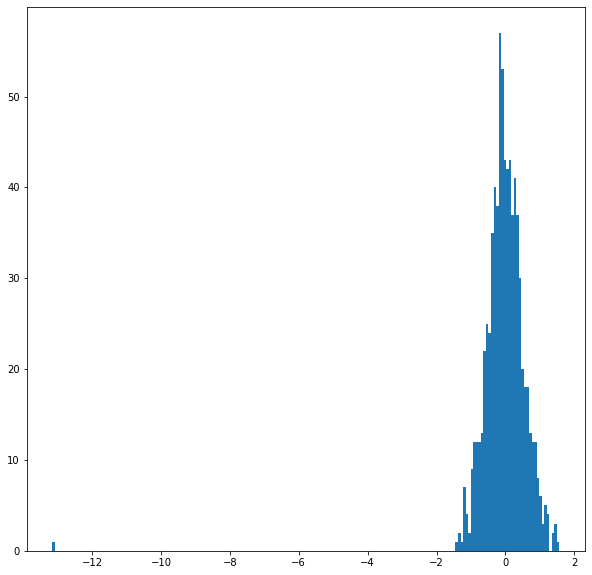

In [77]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = hidden_states[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

In [78]:
# `hidden_states` is a Python list.
print('      Type of hidden_states: ', type(hidden_states))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', hidden_states[0].size())

      Type of hidden_states:  <class 'tuple'>
Tensor shape for each layer:  torch.Size([1, 22, 768])


In [79]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([13, 1, 22, 768])

In [80]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 22, 768])

In [81]:
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([22, 13, 768])

In [84]:
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    
    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Shape is: 22 x 3072


In [85]:
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 22 x 768


In [86]:
# `hidden_states` has shape [13 x 1 x 22 x 768]

# `token_vecs` is a tensor with shape [22 x 768]
token_vecs = hidden_states[-2][0]

# Calculate the average of all 22 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)

# ----------------------------------------------------------

In [64]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
!pip install transformers

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("/content/CUB_captions.csv", header=None, names=['Label',  'ID', 'Sentences'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

In [67]:
# Get the lists of sentences and their labels.
import numpy as np

sentences = df.Sentences.values
labels_text = df.Label.values
labels = df.ID.values

labels = np.delete(labels, 0)
labels_text = np.delete(labels_text, 0)
sentences = np.delete(sentences, 0)

In [68]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


INFO:transformers.tokenization_utils_base:loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [69]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
    if  len(input_ids) == 80:
      print('sent with max len :', sent)
      print('number of words insent with max len :', len(sent.split()))
      print('index of sent with max len :', np.where(sentences==sent))


print('Max sentence length: ', max_len)

atwal = []
for i in sentences:
  atwal.append(len(i.split()))
atwal.sort(reverse=True)
print('Max number of words in a sentnces length: ', atwal[0])

Max sentence length:  70
Max number of words in a sentnces length:  55


In [71]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation=True
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = labels.astype(int)
labels = torch.tensor(labels)

segments_ids = []
for i in range(input_ids.size()[0]):
  segments_id = [1] * input_ids.size()[1]
  segments_ids.append(segments_id)

segments_ids = torch.tensor(segments_ids)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  a bird with a very long wing span and a long pointed beak.
Token IDs: tensor([  101,  1037,  4743,  2007,  1037,  2200,  2146,  3358,  8487,  1998,
         1037,  2146,  4197, 23525,  1012,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [136]:
segments_ids.size()

torch.Size([8855, 64])

In [95]:
input_ids.size()

torch.Size([8855, 64])

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, segments_ids, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(1 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

In [138]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.cuda()
model.eval()

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

In [155]:
import random
import numpy as np
k = 0
for step, batch in enumerate(train_dataloader):
  if step % 40 == 0 :  
    # As we unpack the batch, we'll also copy each tensor to the GPU using the 
    # `to` method.
    #
    # `batch` contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: labels 
    b_input_ids = batch[0].to(device)
    b_segments_ids = batch[1].to(device)
    b_labels = batch[2].to(device)
    print(device,'=> ', step)
    print("b_segments_ids.size()")
    print(b_segments_ids.size())
    print("b_input_ids.size()")
    print(b_input_ids.size())
    #print(b_segments_ids[0])


    with torch.no_grad():
          outputs = model(b_input_ids, b_segments_ids)
          hidden_states = outputs[2]
    

    print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
    layer_i = 0
    print ("Number of batches:", len(hidden_states[layer_i]))
    batch_i = 0
    print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
    token_i = 0
    print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))


    # Concatenate the tensors for all layers. We use `stack` here to
    # create a new dimension in the tensor.
    token_embeddings = torch.stack(hidden_states, dim=0)
    print('token_embeddings.size()', token_embeddings.size())


    # Swap dimensions 0 and 1.
    token_embeddings = token_embeddings.permute(1,2,0,3)
    print('token_embeddings.size()', token_embeddings.size())


    word_vecs_sum = []
    for sentence in token_embeddings:
      # `sentence` is a [64 x 12 x 768] tensor.
      
      # Stores the token vectors, with shape [64 x 768]
      token_vecs_sum = []
      # For each token in the sentence...
      
      for token in sentence:
        # `token` is a [12 x 768] tensor
        # Sum the vectors from the last four layers.
        sum_vec = torch.sum(token[-4:], dim=0)
        # Use `sum_vec` to represent `token`.
        token_vecs_sum.append(sum_vec)

      # Use `token_vecs_sum` to represent `sentence`.
      word_vecs_sum.append(token_vecs_sum)

    print ('Shape is: %d x %d x %d' % (len(word_vecs_sum), len(word_vecs_sum[0]), len(word_vecs_sum[0][0])))


    # `hidden_states` has shape [13 x 32 x 64 x 768]
    # `token_vecs` is a tensor with shape [64 x 768]
    token_vecs = hidden_states[-2]

    # Calculate the average of all 64 token vectors.
    sentence_embedding = torch.mean(token_vecs, dim=1)
    print('sentence_embedding.size()', sentence_embedding.size())


cuda =>  0
b_segments_ids.size()
torch.Size([32, 64])
b_input_ids.size()
torch.Size([32, 64])
Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 32
Number of tokens: 64
Number of hidden units: 768
token_embeddings.size() torch.Size([13, 32, 64, 768])
token_embeddings.size() torch.Size([32, 64, 13, 768])
Shape is: 32 x 64 x 768
sentence_embedding.size() torch.Size([32, 768])
cuda =>  40
b_segments_ids.size()
torch.Size([32, 64])
b_input_ids.size()
torch.Size([32, 64])
Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 32
Number of tokens: 64
Number of hidden units: 768
token_embeddings.size() torch.Size([13, 32, 64, 768])
token_embeddings.size() torch.Size([32, 64, 13, 768])
Shape is: 32 x 64 x 768
sentence_embedding.size() torch.Size([32, 768])
cuda =>  80
b_segments_ids.size()
torch.Size([32, 64])
b_input_ids.size()
torch.Size([32, 64])
Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 32
Number of